In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
#from cvaei.models.cvae_inference import CVAE
from cvaei.models.multitask_cvae import MultiTaskCVAE
from cvaei.examples.MA2 import MovingAverage2

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


# Initialise the Model

In [4]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = ma2.prepare_data(10000)
observed_data = ma2.observed_data()
ma2.check_normalizer()


Training Theta Shape: torch.Size([10000, 2])
Training Data Shape: torch.Size([10000, 100])
Validation Theta Shape: torch.Size([10000, 2])
Validation Data Shape: torch.Size([10000, 100])
Normalization and denormalization process is consistent for both parameters and observed data.


In [5]:
ma2.get_info()

theta_normalizer uses device: cpu
data_normalizer uses device: cpu


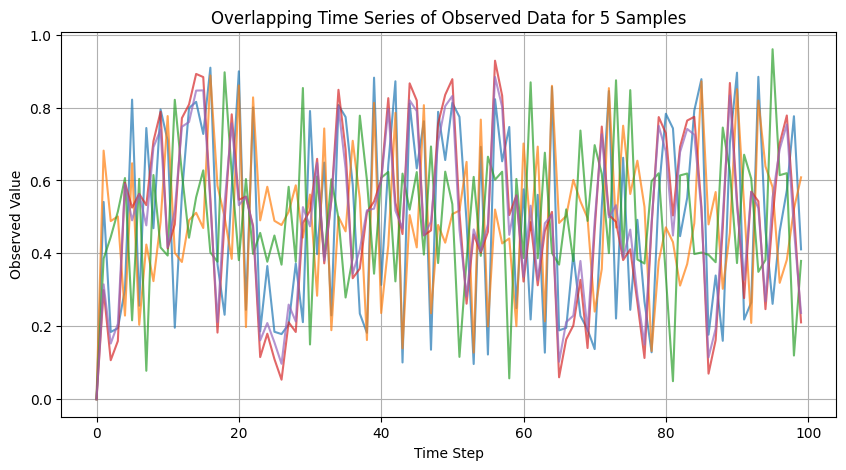

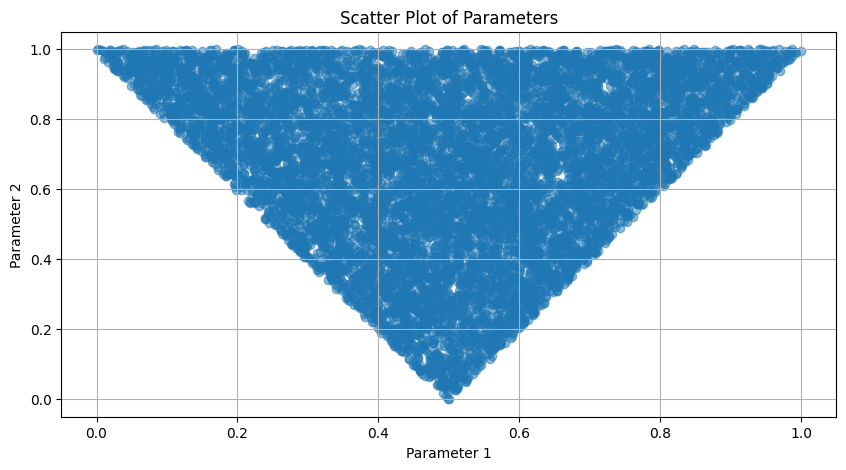

In [6]:
ma2.plot_observation(train_data_norm)
ma2.plot_prior(train_theta_norm)

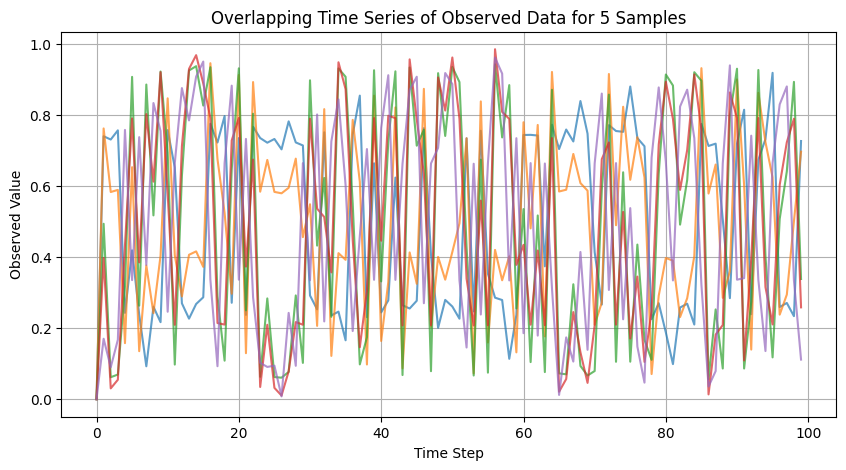

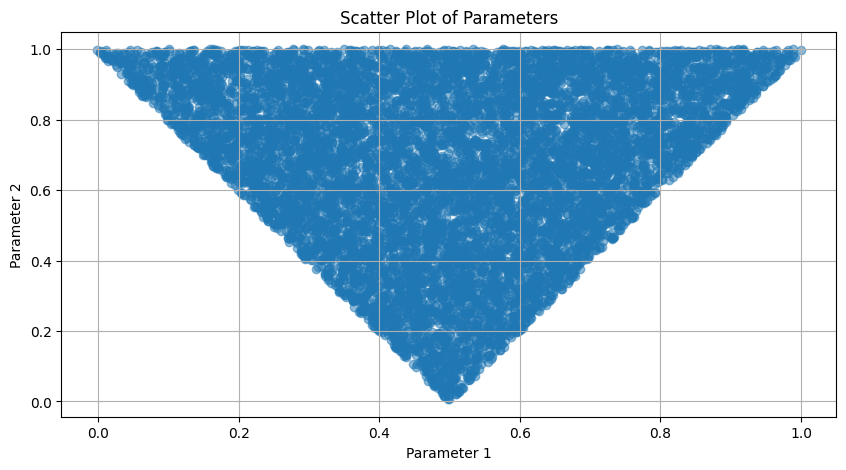

In [7]:
ma2.plot_observation(val_data_norm)
ma2.plot_prior(val_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [200,200]
decoder_hidden_dims = [200,200]
activation_fn = nn.ReLU()

# network = CVAE(input_dim=input_dim, 
#                latent_dim=latent_dim, 
#                output_dim=input_dim,
#                 conditional_dim=conditional_dim,
#                 encoder_hidden_dims=encoder_hidden_dims,
#                 decoder_hidden_dims=decoder_hidden_dims,
#                 activation_fn = activation_fn)

network = MultiTaskCVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=1.0)


optimizer = optim.AdamW(network.parameters(), lr=1e-4)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

print(network)

MultiTaskCVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=200, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): MultiTaskDecoder(
    (layers): Sequential(
      (0): Linear(in_features=110, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (output_layer_1): Linear(in_features=200, out_features=2, bias=True)
    (output_layer_2): Linear(in_features=200, out_features=100, bias=True)
  )
)


In [9]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=100,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= ma2.simulator,
                    patience=100)

Using CPU for training.
Epoch 1/100: Beta: 0.0, total_loss: 30.9114, recon_loss: 0.7361, misfit_loss: 30.1752, kl_div: 0.0000
Epoch 1/100 Validation: total_loss: 29.2155, recon_loss: 0.7172, misfit_loss: 28.4983, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.00292155
Epoch 2/100: Beta: 0.0, total_loss: 27.8288, recon_loss: 0.7095, misfit_loss: 27.1173, kl_div: 0.0020
Epoch 2/100 Validation: total_loss: 25.8521, recon_loss: 0.6881, misfit_loss: 25.1610, kl_div: 0.0030

Epoch 2: Validation loss improved to 0.00258521
Epoch 3/100: Beta: 0.0, total_loss: 24.0135, recon_loss: 0.6663, misfit_loss: 23.3387, kl_div: 0.0086
Epoch 3/100 Validation: total_loss: 21.3748, recon_loss: 0.6219, misfit_loss: 20.7402, kl_div: 0.0127

Epoch 3: Validation loss improved to 0.00213748
Epoch 4/100: Beta: 0.1, total_loss: 18.9722, recon_loss: 0.5812, misfit_loss: 18.3650, kl_div: 0.0260
Epoch 4/100 Validation: total_loss: 15.6659, recon_loss: 0.5082, misfit_loss: 15.1212, kl_div: 0.0365

Epoch 4: Val

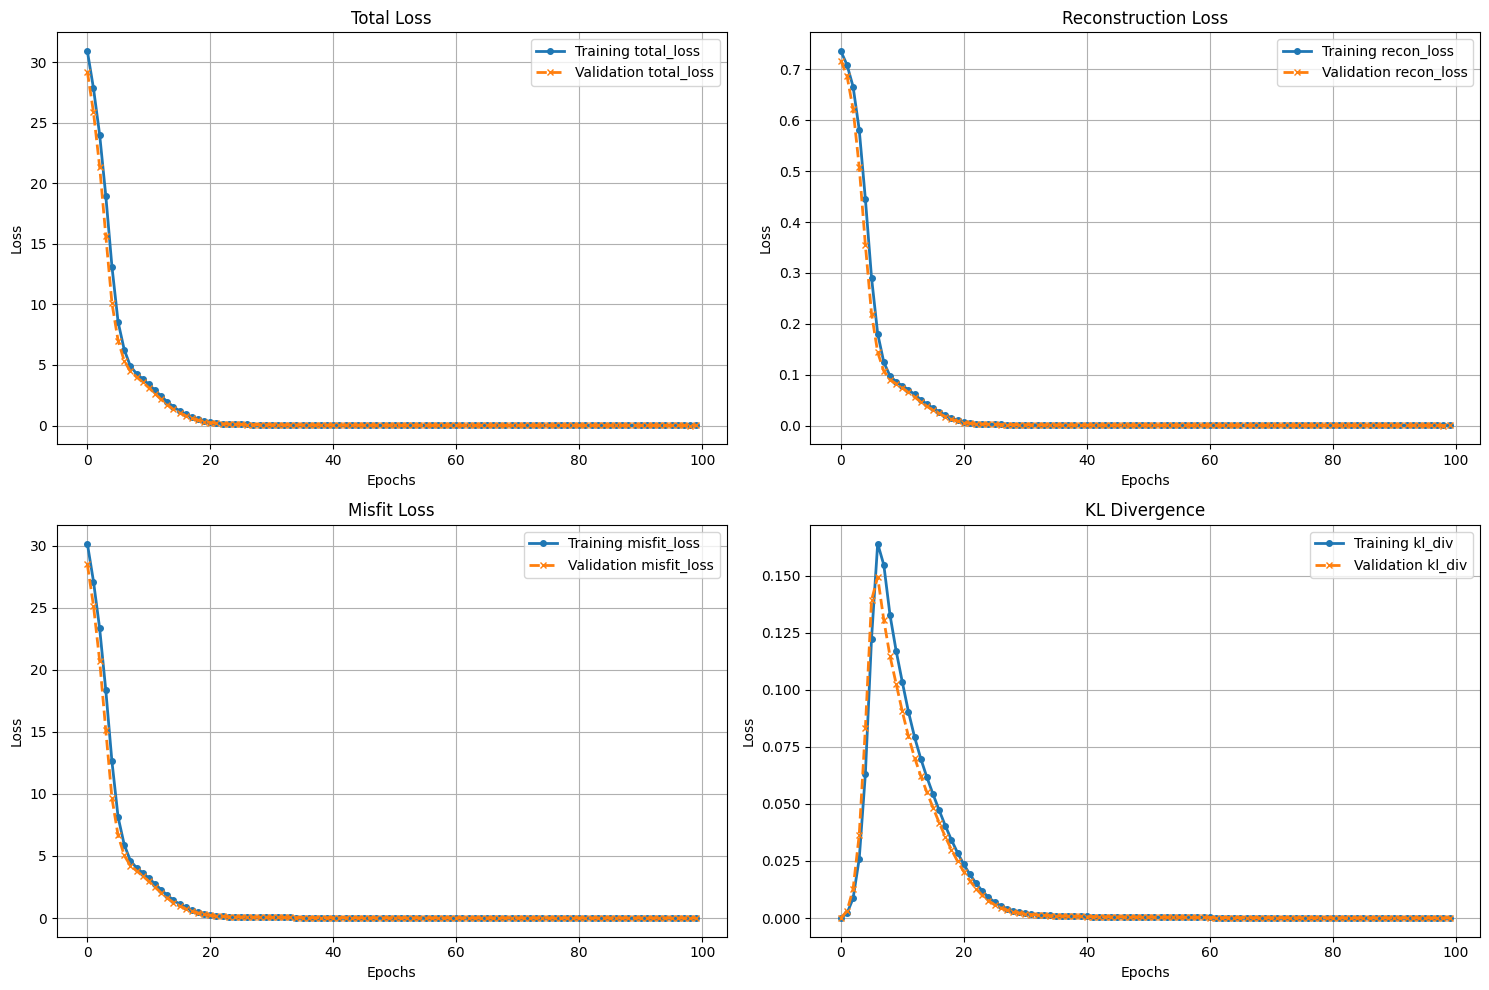

In [10]:
network.plot_loss()

# Inference

In [11]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


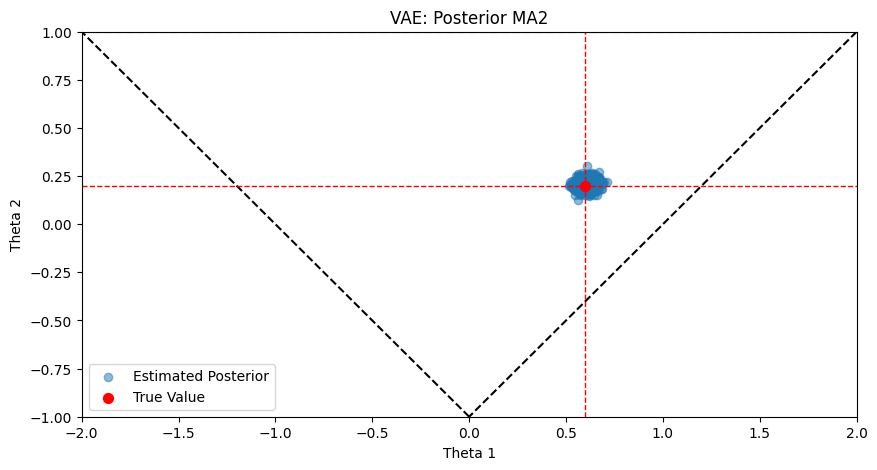

In [12]:
ma2.plot_posterior(post)

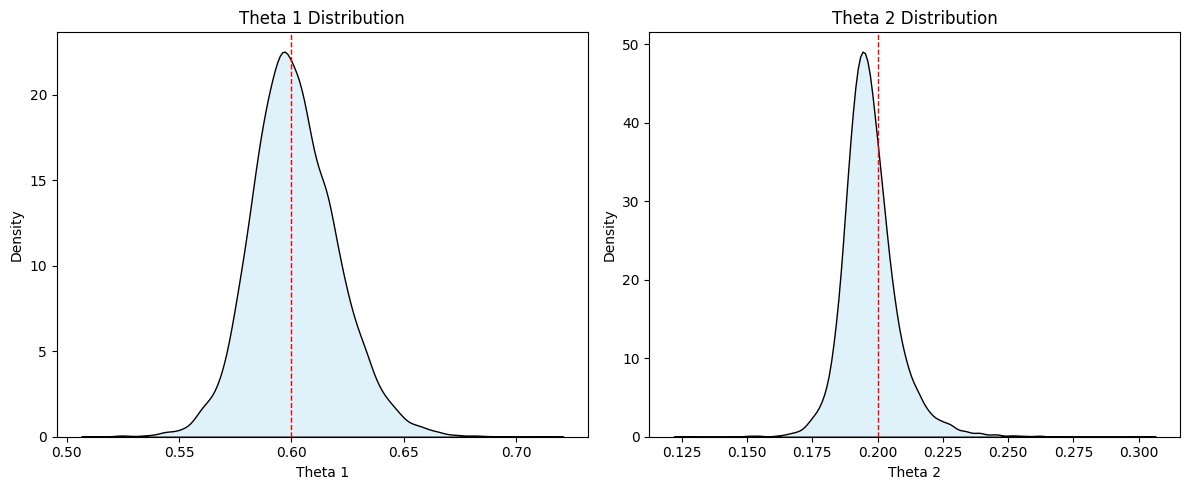

In [13]:
ma2.posterior_hist(post, kde = True)